In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
from astropy.io import fits
import astropy.units as u
import h5py
from astropy.utils.console import ProgressBar
from astropy.coordinates import SkyCoord, Angle
from aesop import EchelleSpectrum
import os

In [2]:
root_dir = '/Users/bmmorris/data/'
target_paths = [os.path.abspath(os.path.join(root_dir, p)) 
                for p in open('/Users/bmmorris/git/aesop/notebooks/freckles_target_paths.txt').read().splitlines()]
spectrum_indices = [p.split('.wfrmcpc')[0][-4:] for p in target_paths]

validated_paths = []

for path in target_paths: 
    try: 
        _ = fits.getheader(path)
        validated_paths.append(path)
    except OSError: 
        print(path)

target_names = [(fits.getheader(p)['OBJNAME'].replace(' ', '').replace('-', '')
                 .replace('+', '').replace('_', ''))
                for p in validated_paths]

In [3]:
from astroquery.simbad import Simbad

s = Simbad()
s.add_votable_fields('flux(V)')
s.add_votable_fields('sptype')

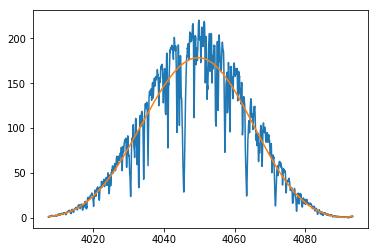

In [4]:
# archive.close() 
archive = h5py.File('archive.hdf5', 'w')

poly_order = 10

for target_path, target_name in zip(target_paths, target_names):
    target_spectrum = EchelleSpectrum.from_fits(target_path)
    object_name = target_spectrum.header['OBJNAME']

    if object_name not in list(archive) and target_name != 'sky': 
        n_orders = len(target_spectrum.spectrum_list)

        dset = archive.create_dataset(object_name, shape=(n_orders, 3+poly_order+1))

        query = s.query_object(object_name)
        v_mag = query['FLUX_V']
        sptype = query['SP_TYPE']
        dset.attrs['V'] = v_mag
        
        if object_name == '61CygA':
            dset.attrs['V'] = [5.21]
        elif object_name == '61CygB':
            dset.attrs['V'] = [6.03]
        elif object_name == 'Kepler-17':
            dset.attrs['V'] = [14.0]
        
        dset.attrs['SP_TYPE'] = str(sptype).split('\n')[2].strip()
        dset.attrs['NAME'] = object_name

        matrix = []
        for order in np.arange(n_orders):
            
            wave, flux = target_spectrum[order].wavelength, target_spectrum[order].flux/target_spectrum.header['EXPTIME']
            polynomial_coefficients = np.polyfit(wave - wave.mean(), flux, 10)

            matrix.append(np.concatenate([[wave.value.mean(), np.median(np.diff(wave.value)), len(wave)], 
                                          polynomial_coefficients]))
            if target_name == 'HD98230' and order == 20:
                plt.plot(wave, flux)
                plt.plot(wave, np.polyval(polynomial_coefficients, wave - wave.mean()))
                plt.show()

        dset[:] = np.array(matrix)
archive.close()

In [5]:
archive = h5py.File('archive.hdf5', 'r+')
sptype_dictionary = dict()

for target in archive:
    dset = archive[target]
    sptype = dset.attrs['SP_TYPE']
    if len(sptype) > 0:  
        sptype_dictionary[sptype] = dset.attrs['NAME']
    elif target == '61CygA': 
        sptype_dictionary['K5V'] = dset.attrs['NAME']
    elif target == '61CygB': 
        sptype_dictionary['K7V'] = dset.attrs['NAME']

from json import dump
dump(sptype_dictionary, open('sptype_dict.json', 'w'))

In [6]:
for target in archive: 
    print(target, archive[target].attrs['V'])

51 Peg [5.46]
61CygA [5.21]
61CygB [6.03]
EK Dra [7.61]
EPIC 211928486 [13.52]
EPIC 211966629 [13.26]
EPIC211928486 [13.52]
EPIC211966629 [13.26]
EQ Vir [9.372]
GJ 4099 [11.36]
GJ 705 [8.17]
GJ 9781A [9.02]
GJ4099 [11.36]
GJ702B [6.07]
HAT P-11 [9.47]
HAT-P-11 [9.47]
HD  82106 [7.197]
HD 10697 [6.279]
HD 113827 [9.391]
HD 122120 [9.04]
HD 129333 [7.61]
HD 14039 [8.27]
HD 145675 [6.67]
HD 145742 [7.55]
HD 178126 [9.215]
HD 182488 [6.356]
HD 209290 [9.146]
HD 210277 [6.63]
HD 220182 [7.36]
HD 222107 [3.82]
HD 266611 [9.745]
HD 38230 [7.36]
HD 42250 [7.43]
HD 50692 [5.748]
HD 5857 [8.92]
HD 6497 [6.401]
HD 67767 [5.73]
HD 73667 [7.582]
HD 79555 [7.925]
HD 88230 [6.61]
HD 89744 [5.72]
HD110833 [7.04]
HD127506 [8.97]
HD134319 [8.41]
HD148467 [8.85]
HD149957 [9.465]
HD151288 [8.799]
HD175742 [8.019]
HD200560 [7.68]
HD221639 [7.19]
HD34411 [4.71]
HD39587 [4.4]
HD41593 [6.74]
HD45088 [6.768]
HD47752 [8.056]
HD62613 [6.56]
HD68017 [6.81]
HD86728 [5.4]
HD87884 [8.13]
HD98230 [4.729]
HR 8832 [5.5